# xDbit - characterization of channel flow

## Measurement of channel lengths

The channel lengths were measured from `xDbit_50um_horizontal.dwg` using Autodesk DWG TrueView 2023 and eDrawings. In eDrawings I determined the perimeter of the inlets/outlets to be 6.9 mm. In TrueView I used the Measure List tool to select all channels (including the inlet and outlets) and print the results by pressing ENTER. The results were copied into a text file and perimeters need to be extracted here.

### Extraction of perimeters from text file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
text_file = r"Z:\Daten\01 HPC\03 Team Meier\08_Projects\37_Spatial_Barcoding\37_54\lengths_horizontal_chip.txt"

file = open(text_file, 'r')
lines = file.readlines()

In [3]:
perimeters = [l for l in lines if "perimeter" in l]
perimeters = [float(p.split(" ")[-1].strip()) for p in perimeters]

data = pd.DataFrame({
    "perimeter": perimeters
})

### Calculate channel length

length = (perimeter - 2 * 6.9mm) / 2

In [4]:
# calc
data["length"] = [(elem - 2*6.9) / 2 for elem in data["perimeter"]]

In [5]:
data["id"] = range(1, len(data)+1)

In [6]:
unique_lengths = np.unique(data.sort_values('length').length)
ldict = {elem: i+1 for i, elem in enumerate(unique_lengths)}

In [7]:
data["length_id"] = [ldict[elem] for elem in data["length"]]

## Measurement results

In [9]:
resfile = r"Z:\Daten\01 HPC\03 Team Meier\08_Projects\37_Spatial_Barcoding\37_54\results.xlsx"
results = pd.read_excel(resfile)

In [10]:
results["length"] = np.unique(data.sort_values("length")["length"].values)

In [12]:
results = results.melt(id_vars="length", value_vars=list("ABCD"))

In [13]:
results = results.rename(columns={"value": "volume"})

### Calculate flow rate from volume

The experiment was run for 60s at 300 mbar.

In [18]:
results["flow rate"] = [elem / 1 for elem in results["volume"]] # in µm/min


## Plot and do linear regression and pearsson

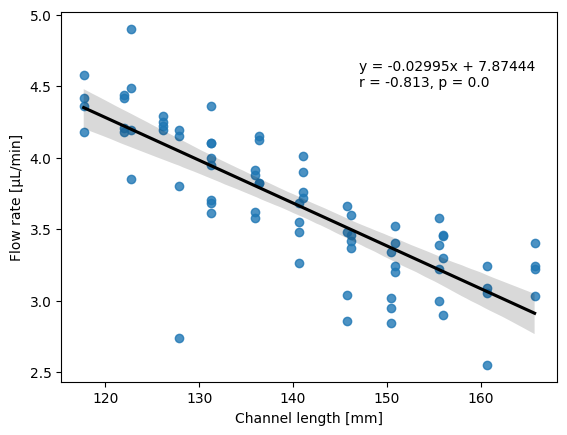

In [21]:
fig, ax = plt.subplots(1,1)

sns.regplot(data=results, 
            x="length", 
            y="flow rate", 
            line_kws={"color": "k"},
            ax=ax)
ax.set_xlabel("Channel length [mm]")
ax.set_ylabel("Flow rate [µL/min]")

# do linear regression
lm = LinearRegression()
x = results["length"].values
y = results["flow rate"].values
lm.fit(x.reshape(-1,1), y.reshape(-1,1))

# get parameters
slope = lm.coef_[0][0]
intercept = lm.intercept_[0]

# calc pearson r
r, p = stats.pearsonr(x=x, y=y)

# add annotation of equation and R²
ax.annotate(
    "y = {}x + {}\nr = {}, p = {}".format(
    round(slope, 5), 
    round(intercept, 5),
    round(r, 3), 
    round(p, 3)
    ), 
            xy=(0.6,0.8), 
            xycoords='axes fraction')

plt.savefig("figures/lineplot_flowrate.pdf")
plt.savefig("figures/lineplot_flowrate.png")
plt.show()